In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
import sys
import ndreg
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import skimage

In [ ]:
import os

### Step 1: Load data

In [ ]:
rmt = BossRemote(cfg_file_or_dict='./intern.cfg')

In [6]:
img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)

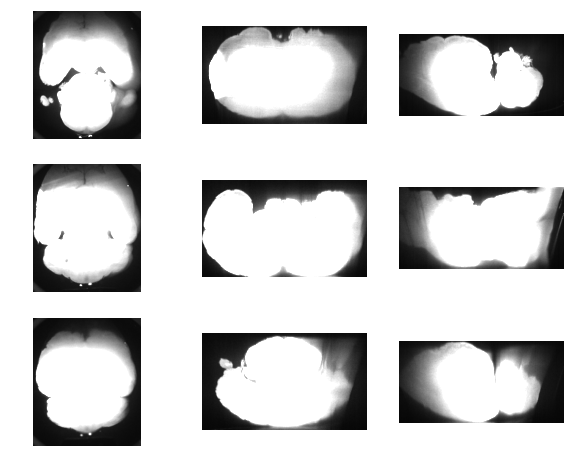

In [7]:
ndreg.imgShow(img, vmax=2500)

# download atlas

In [8]:
atlas = ndreg.download_ara(rmt, 50)

## create the mask

In [9]:
mask_sitk = preprocessor.create_mask(img, use_triangle=True)

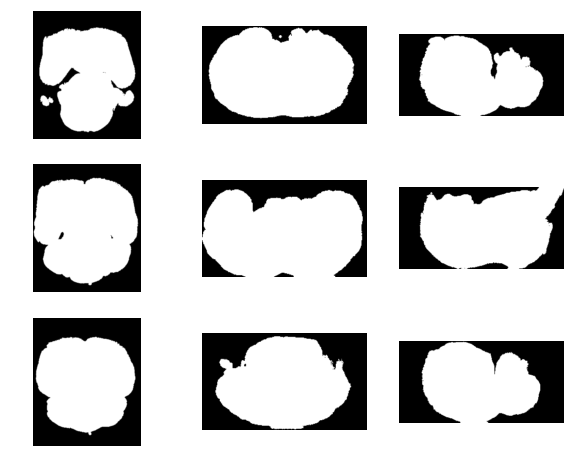

In [10]:
ndreg.imgShow(mask_sitk, vmax=1)

### Correct Bias field

In [11]:
# img_bc = preprocessor.correct_bias_field(img, scale=0.25, mask=mask_sitk,
#                                          spline_order=4, num_control_pts=[5,5,5],
#                                          niters=[50, 50, 50, 50])
img_bc = img

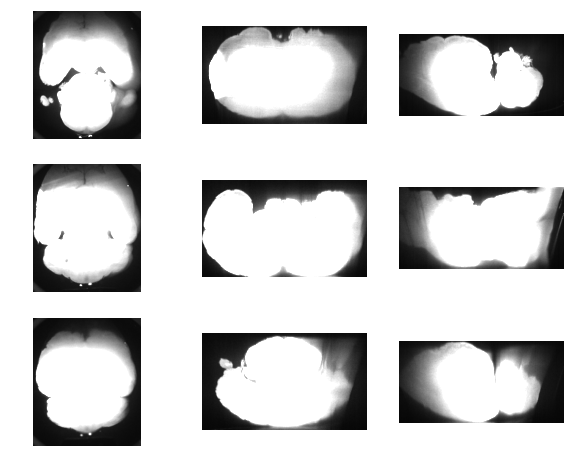

In [12]:
ndreg.imgShow(img_bc, vmax=2500)

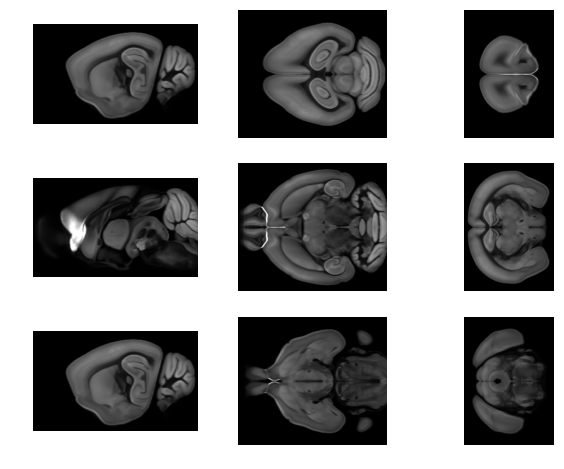

In [13]:
ndreg.imgShow(atlas)

# Resampling Images

In [14]:
# print(atlas.GetMetaData())
print(img_bc.GetSpacing())

(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)


In [15]:
atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(atlas, img_bc, "pir", "lps", 0.05)

[13.209600000000002, 8.0, 11.4]


In [16]:
img_width, img_height, img_depth = img_bc_ds.GetSize()
atlas_width, atlas_height, atlas_depth = atlas_ds.GetSize()

In [17]:
print('atlas width: {}, height: {}, depth: {}'.format(atlas_width, atlas_height, atlas_depth))
print('img width: {}, height: {}, depth: {}'.format(img_width, img_height, img_depth))

atlas width: 264, height: 160, depth: 228
img width: 264, height: 160, depth: 228


In [ ]:
ndreg.imgShow(atlas_ds)

In [ ]:
ndreg.imgShow(img_bc_ds, vmax=2000)

In [ ]:
img_bc_ds = sitk.Normalize(img_bc_ds)
atlas_ds = sitk.Normalize(atlas_ds)

# Registration part

In [ ]:
final_transform = registerer.register_affine(atlas_ds, 
                                            img_bc_ds,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.6, 0.3, 0.150],
                                            verbose=True)

In [ ]:
out_atlas = registerer.resample(atlas_ds, final_transform, atlas_ds)
out_target = registerer.resample(img_bc_ds, final_transform.GetInverse(), img_bc_ds)

In [ ]:
ndreg.imgShow(out_atlas)

In [ ]:
ndreg.imgShow(out_target)

In [ ]:
ndreg.imgShow(ndreg.imgChecker(out_atlas, img_bc_ds), vmax=1)

In [ ]:
atlas_kernel = [5,5,5]

In [ ]:
out_target_whitened = preprocessor.whiten(out_target, radius=atlas_kernel)
atlas_ds_whitened = preprocessor.whiten(atlas_ds, radius=atlas_kernel)

In [ ]:
out_atlas_whitened = preprocessor.whiten(out_atlasm radius=atlas_kernel)
img_bc_ds_whitened = whiten(img_bc_ds, radius=atlas_kernel)

In [ ]:
ndreg.imgShow(out_target_whitened)

In [ ]:
ndreg.imgShow(out_atlas_whitened, vmax=300)

In [ ]:
ndreg.imgShow(img_bc_ds_whitened)

In [ ]:
ndreg.imgShow(atlas_ds_whitened)

## lddmm

In [ ]:
atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas2_whitened), 
                                                          target_img=sitk.Normalize(img_bc_ds_whitened),
                                                          alpha_list=[0.02], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=1e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=300, verbose=True)

In [ ]:
ndreg.imgShow(atlas_lddmm)

In [ ]:
ndreg.imgShow(ndreg.imgChecker(img_bc_ds_whitened, atlas_lddmm), vmax=1)

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

import sys
import ndreg
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import skimage

import os

### Step 1: Load data

rmt = BossRemote(cfg_file_or_dict='../.intern/intern.cfg')

img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)

ndreg.imgShow(sitk.Cast(out, sitk.sitkUInt16), vmax=500)

# download atlas

atlas = ndreg.download_ara(rmt, 50)

## create the mask

mask_sitk = preprocessor.create_mask(img, use_triangle=True)

ndreg.imgShow(mask_sitk, vmax=1)

### Correct Bias field

img_bc = preprocessor.correct_bias_field(img, scale=0.25, mask=mask_sitk,
                                         spline_order=4, num_control_pts=[5,5,5],
                                         niters=[200, 200, 100, 50])

ndreg.imgShow(img_bc, vmax=2500)

ndreg.imgShow(atlas)

# Resampling Images

atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(atlas, img_bc, "pir", "lps", 0.05)

ndreg.imgShow(atlas_ds)

ndreg.imgShow(img_bc_ds, vmax=2000)

img_bc_ds = sitk.Normalize(img_bc_ds)
atlas_ds = sitk.Normalize(atlas_ds)

# Registration part

final_transform = registerer.register_affine(atlas_ds, 
                                            img_bc_ds,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.6, 0.3, 0.150],
                                            verbose=True)

out_atlas = registerer.resample(atlas_ds, final_transform, atlas_ds)
out_target = registerer.resample(img_bc_ds, final_transform.GetInverse(), img_bc_ds)

ndreg.imgShow(out_atlas)

ndreg.imgShow(out_target)

ndreg.imgShow(ndreg.imgChecker(out_atlas, img_bc_ds), vmax=1)

out_target_whitened = preprocessor.whiten(out_target, radius=[10,10,10])
atlas_ds_whitened = preprocessor.whiten(atlas_ds, radius=[10,10,10])

out_atlas_whitened = preprocessor.whiten(out_atlasm radius=[10,10,10])
img_bc_ds_whitened = whiten(img_bc_ds, radius=[10,10,10])

ndreg.imgShow(out_target_whitened)

ndreg.imgShow(out_atlas_whitened, vmax=300)

ndreg.imgShow(img_bc_ds_whitened)

ndreg.imgShow(atlas_ds_whitened)

## lddmm

atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas2_whitened), 
                                                          target_img=sitk.Normalize(img_bc_ds_whitened),
                                                          alpha_list=[0.02], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=1e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=300, verbose=True)

ndreg.imgShow(atlas_lddmm)

ndreg.imgShow(ndreg.imgChecker(img_bc_ds_whitened, atlas_lddmm), vmax=1)